## Shale Gas EUR Prediction
---

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams['figure.figsize'] = (15.0, 7.0)
sns.set_theme()

Data Set Source (Kaggle): https://www.kaggle.com/datasets/minhazengg/shale-wells-dataset?resource=download

In [77]:
shale_gas_raw = pd.read_csv('data/Shale_Gas_Wells_DataSet.csv')
shale_gas_raw.head()

,Stage Spacing,bbl/ft,Well Spacing,Dip,Thickness,Lateral Length,Injection Rate,Porosity,ISIP,Water Saturation,Percentage of LG,Pressure Gradient,Proppant Loading,EUR,Category
0,140,38,850,0,165,8543,64,8.3,8200,17.1,38.0,0.95,3012,13.3,New_Design
1,140,30,900,0,174,8336,60,7.8,8061,16.0,59.3,0.95,2771,12.5,New_Design
2,140,30,900,0,174,9361,65,7.8,8061,16.0,59.3,0.95,3067,16.9,New_Design
3,140,30,950,0,175,9110,69,8.3,7922,15.7,66.9,0.95,3130,16.5,New_Design
4,140,30,950,0,175,9310,67,8.3,7922,15.7,66.9,0.95,2991,17.4,New_Design


In [78]:
shale_gas_raw.shape

(506, 15)

---
__1. Data Spliting__

We will separate original data as training and testing in order to avoid data leakege during data pre-processing, feature engineering, and transformation. In this subject we are going to use 70-30 as training and testing respectively done by `StratifiedShuffleSplit` method.

In [79]:
from sklearn.model_selection import  StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in split.split(shale_gas_raw, shale_gas_raw.Category):
 strat_train_set = shale_gas_raw.loc[train_index]
 strat_test_set = shale_gas_raw.loc[test_index]

> 1.1. Missing Value Consistency Check

After spliting we concern about data integration, for instance about missing data in which showing inconsistency between training & spliting. In order to check it, we a chunk of code below

_On Training Data Set_

In [80]:
total = strat_train_set.isnull().sum().sort_values(ascending=False)
percent = (strat_train_set.isnull().sum()/strat_train_set.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Stage Spacing,0,0.0
bbl/ft,0,0.0
Well Spacing,0,0.0
Dip,0,0.0
Thickness,0,0.0
Lateral Length,0,0.0
Injection Rate,0,0.0
Porosity,0,0.0
ISIP,0,0.0
Water Saturation,0,0.0


_On Testing Data Set_

In [81]:
total = strat_test_set.isnull().sum().sort_values(ascending=False)
percent = (strat_test_set.isnull().sum()/strat_test_set.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Stage Spacing,0,0.0
bbl/ft,0,0.0
Well Spacing,0,0.0
Dip,0,0.0
Thickness,0,0.0
Lateral Length,0,0.0
Injection Rate,0,0.0
Porosity,0,0.0
ISIP,0,0.0
Water Saturation,0,0.0


Apparently, we safe to conduct further step since there is no inconsistency in missing value, Moreover, in fact, we don't have any missing value between those data set.

> 1.2. Data Drifting Evaluation

On this chapter we are going to conduct drifting analysis to check whether our data after splitting still have similar data distribution between training & testing

In [82]:
from collections import Counter

def drifting_histograms(df, dfs, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        try:
            df[var_name].hist(bins=40,ax=ax,color = 'green',alpha=0.5, figsize = (15, 24), density=True)
            dfs[var_name].hist(bins=40,ax=ax,color = 'r',alpha=0.5, figsize = (15, 24), density=True)
        except:
            cnt = Counter(df[var_name])
            cnts = Counter(dfs[var_name])
            cnt.hist(bins=40,ax=ax,color = 'green',alpha=0.5, figsize = (15, 24), density=True)
            cnts.hist(bins=40,ax=ax,color = 'r',alpha=0.5, figsize = (15, 24), density=True)

        ax.set_title(var_name, fontsize = 10)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 8)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = 8)
        ax.set_xlabel('')
    fig.tight_layout(rect = [0, 0.03, 1, 0.95])  # Improves appearance a bit.
    plt.show()

In [83]:
variables = strat_train_set.columns
variables

Index(['Stage Spacing', 'bbl/ft', 'Well Spacing', 'Dip', 'Thickness',
       'Lateral Length', 'Injection Rate', 'Porosity', 'ISIP',
       'Water Saturation', 'Percentage of LG', 'Pressure Gradient',
       'Proppant Loading', 'EUR', 'Category'],
      dtype='object')

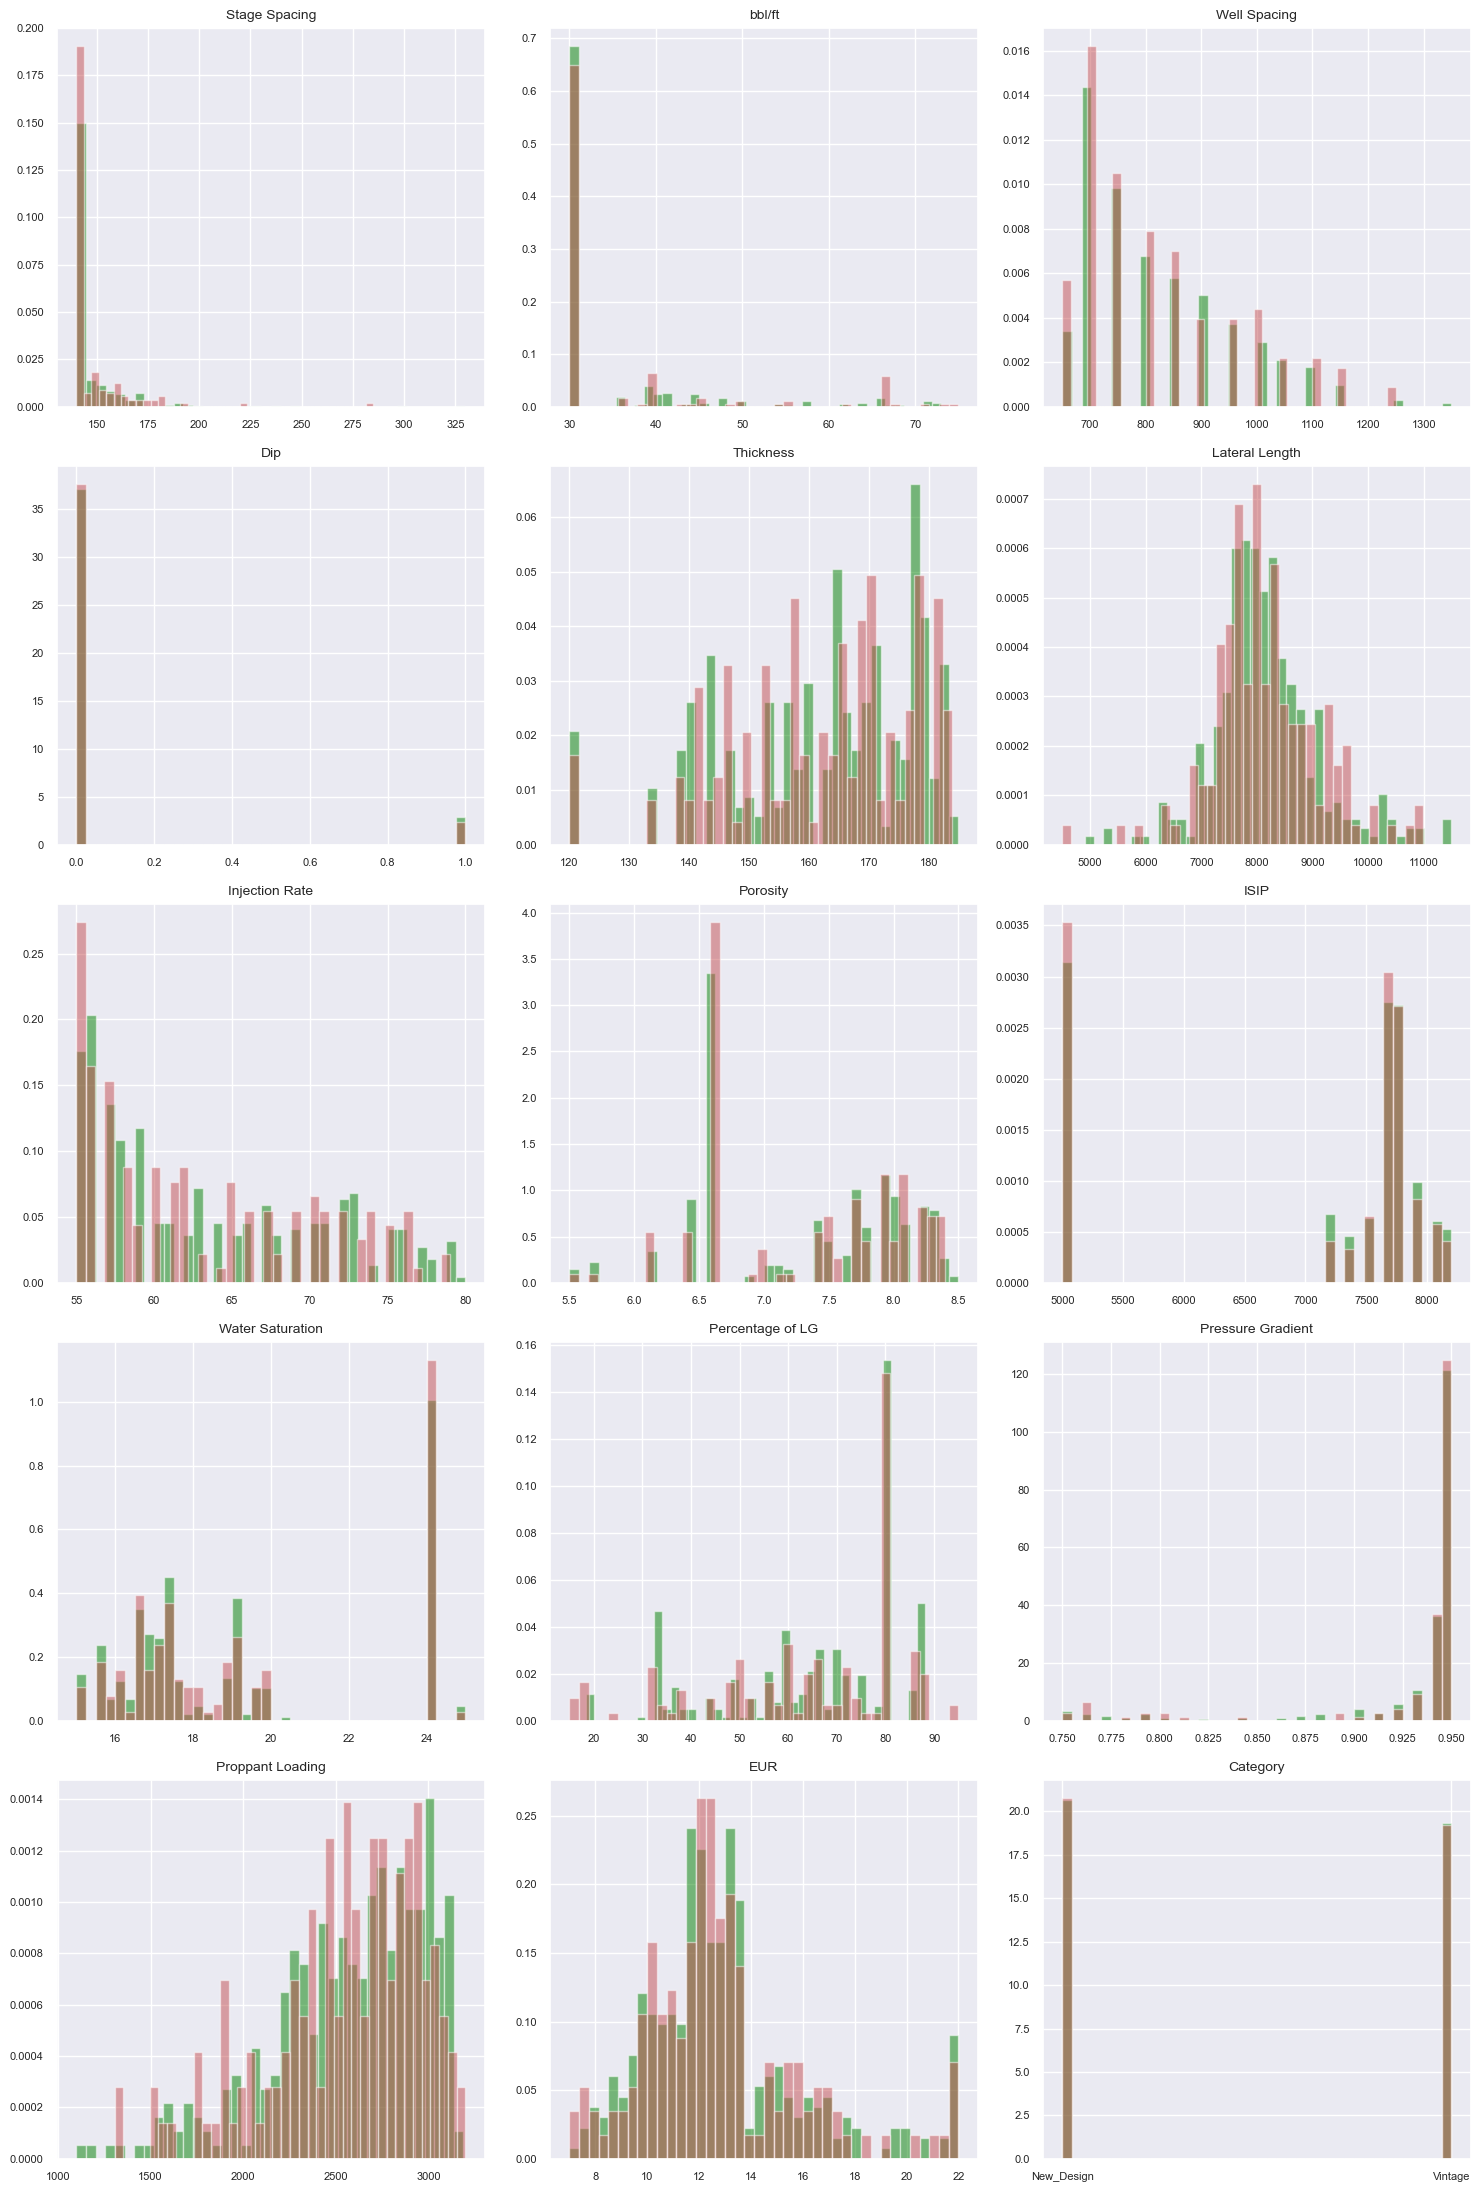

In [84]:
drifting_histograms(strat_train_set, strat_test_set, variables, 5, 3)

From plots above, We can imply that both training & testing set have similar data distribution and this could be a good indication that we don't experience any data drifting problems. This assumption is important in machine learning.

---
__2. Exploratory Data Analysis (EDA)__

In [85]:
strat_train_set.head()

,Stage Spacing,bbl/ft,Well Spacing,Dip,Thickness,Lateral Length,Injection Rate,Porosity,ISIP,Water Saturation,Percentage of LG,Pressure Gradient,Proppant Loading,EUR,Category
274,140,48,850,1,177,8788,72,7.8,7783,16.3,57.6,0.95,3096,16.1,New_Design
60,140,41,1050,0,176,7424,64,8.0,7226,16.9,75.4,0.95,2538,11.6,Vintage
293,140,30,950,0,178,7942,76,7.0,7783,16.9,43.9,0.95,2803,13.3,Vintage
486,152,30,800,0,159,7924,60,6.6,5000,24.1,79.7,0.95,2432,11.7,Vintage
160,143,30,700,1,156,8107,57,6.4,7643,19.1,32.9,0.92,2982,14.3,New_Design


> 2.1. General Information

In [100]:
strat_train_set.describe().T

,count,mean,std,min,25%,50%,75%,max
Stage Spacing,354.0,147.618644,19.040699,140.00,140.000,141.00,147.00,330.00
bbl/ft,354.0,34.824859,9.957294,30.00,30.000,30.00,36.00,73.00
Well Spacing,354.0,819.632768,133.179172,650.00,700.000,800.00,900.00,1350.00
Dip,354.0,0.073446,0.261237,0.00,0.000,0.00,0.00,1.00
Thickness,354.0,162.460452,15.652019,120.00,153.000,165.00,177.00,185.00
Lateral Length,354.0,8153.296610,937.238028,4905.00,7632.500,8053.00,8593.75,11500.00
Injection Rate,354.0,63.197740,7.314497,55.00,57.000,61.00,69.00,80.00
Porosity,354.0,7.330508,0.751147,5.50,6.600,7.50,8.00,8.50
ISIP,354.0,7035.053672,1198.247256,5000.00,5556.500,7643.00,7783.00,8200.00
Water Saturation,354.0,19.139266,3.191501,15.00,16.800,17.70,24.10,25.00


Statisctics summary from table above implies that our training dataset have reasonable entries representing by not having data magnitude that is categorized as anomaly in petroleum engineering knowledge.

In [86]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 274 to 277
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Stage Spacing      354 non-null    int64  
 1   bbl/ft             354 non-null    int64  
 2   Well Spacing       354 non-null    int64  
 3   Dip                354 non-null    int64  
 4   Thickness          354 non-null    int64  
 5   Lateral Length     354 non-null    int64  
 6   Injection Rate     354 non-null    int64  
 7   Porosity           354 non-null    float64
 8   ISIP               354 non-null    int64  
 9   Water Saturation   354 non-null    float64
 10  Percentage of LG   354 non-null    float64
 11  Pressure Gradient  354 non-null    float64
 12  Proppant Loading   354 non-null    int64  
 13  EUR                354 non-null    float64
 14  Category           354 non-null    object 
dtypes: float64(5), int64(9), object(1)
memory usage: 44.2+ KB


According to the table above, our training dataset has 15 features and 1 target (EUR). Every feature doesn't have null value and various data type where majority (9 features) might be presented as `int64`. 6 features are `float64` and just only 1 is categorized as `object`.

> 2.2. Wrong Entries Checking

In [87]:
def object_wrong_entries_checking(train, test):
    col_ = train.columns

    print('## Entries in Training Data Set:')
    for i in col_:
        if train[i].dtype == object:
            print('{}: {}'.format(i, train[i].unique()))

        else:
            continue

    print('---------------------------------------------------------------')

    print('## Entries in Test Data Set:')
    for i in col_:
        if test[i].dtype == object:
            print('{}: {}'.format(i, test[i].unique()))

        else:
            continue

In [92]:
object_wrong_entries_checking(strat_train_set, strat_test_set)

## Entries in Training Data Set:
Category: ['New_Design' 'Vintage']
---------------------------------------------------------------
## Entries in Test Data Set:
Category: ['Vintage' 'New_Design']


Many mistake could exist in dataset for instance a feature containing a wrong symbol such as '-, %, #, &' and many more. By using our function `object_wrong_entries_checking` we believe that this mistake could be identified simply by looking to data that has data type as 'object'. We don't test on integer or float data type since it is simply not possible that wrong symbol exists. Having these mistake identified, we could clean it up in data cleaning process but for this project, we are blessed that we don't have any mistake in data entries both for training & test dataset.

NOTE: Although we are not able to look at the future meaning that we are not allowed to see testing dataset but this processes aim to inform us in advance that special data handling/ pipeline is needed on this feature to overcome data mistake if it's showing some wrong entries on each/ both dataset.

> 2.3. Inconsistent Entries Checking

In [93]:
def object_inconsistent_entries(train, test):
    col_ = train.columns

    for i in col_:
        if train[i].dtype == object:
            print('{}, {}'.format(i, set(test[i]).difference(set(train[i]))))

        else:
            continue

In [94]:
object_inconsistent_entries(strat_train_set, strat_test_set)

Category, set()


By using `object_inconsistent_entries` function we are looking for inconsistent entries in train & test dataset. We belive this risk only occurs in 'object' data type but not in other type. If we separate a dataset to become train & test but some of the entries in test dataset that we are intended to be isolated from train dataset have unique value but not exist in train dataset so our model could be in trouble since we are not prepared in data preparation and modeling.

Luckily, for this project we don't have any anomalies in train & test dataset. So it is safe to say that object type feature are consistent.

NOTE: Although we are not able to look at the future meaning that we are not allowed to see testing dataset but this processes aim to inform us in advance that special data handling/ pipeline is needed on this feature to overcome data inconsistencies if it occures on each/ both dataset.

> 2.4. Feature Explanation

for each features

> 2.5. Data Characteristics

In [109]:
from collections import Counter
from statsmodels.graphics.gofplots import qqplot

def data_char(dataset):
    var_ = dataset.columns

    fig=plt.figure(figsize=(20, 50))
    for i, var_name in enumerate(var_):
        ax=fig.add_subplot(var_.shape[0], 3, (i*3)+1)
        bx=fig.add_subplot(var_.shape[0], 3, (i*3)+2)
        cx=fig.add_subplot(var_.shape[0], 3, (i*3)+3)
        try:
            sns.histplot(x=var_name, data=dataset, stat='probability', ax=ax, color='skyblue')
            sns.boxplot(x=var_name, data=dataset, ax=bx, color='salmon')
            qqplot(strat_train_set[var_name], fit=True, line='s', ax=cx, markerfacecolor='c', markeredgecolor='c', alpha=0.3)

        except:
            break

    fig.tight_layout(rect = [0, 0.03, 1, 0.95])  # Improves appearance a bit.
    plt.show();

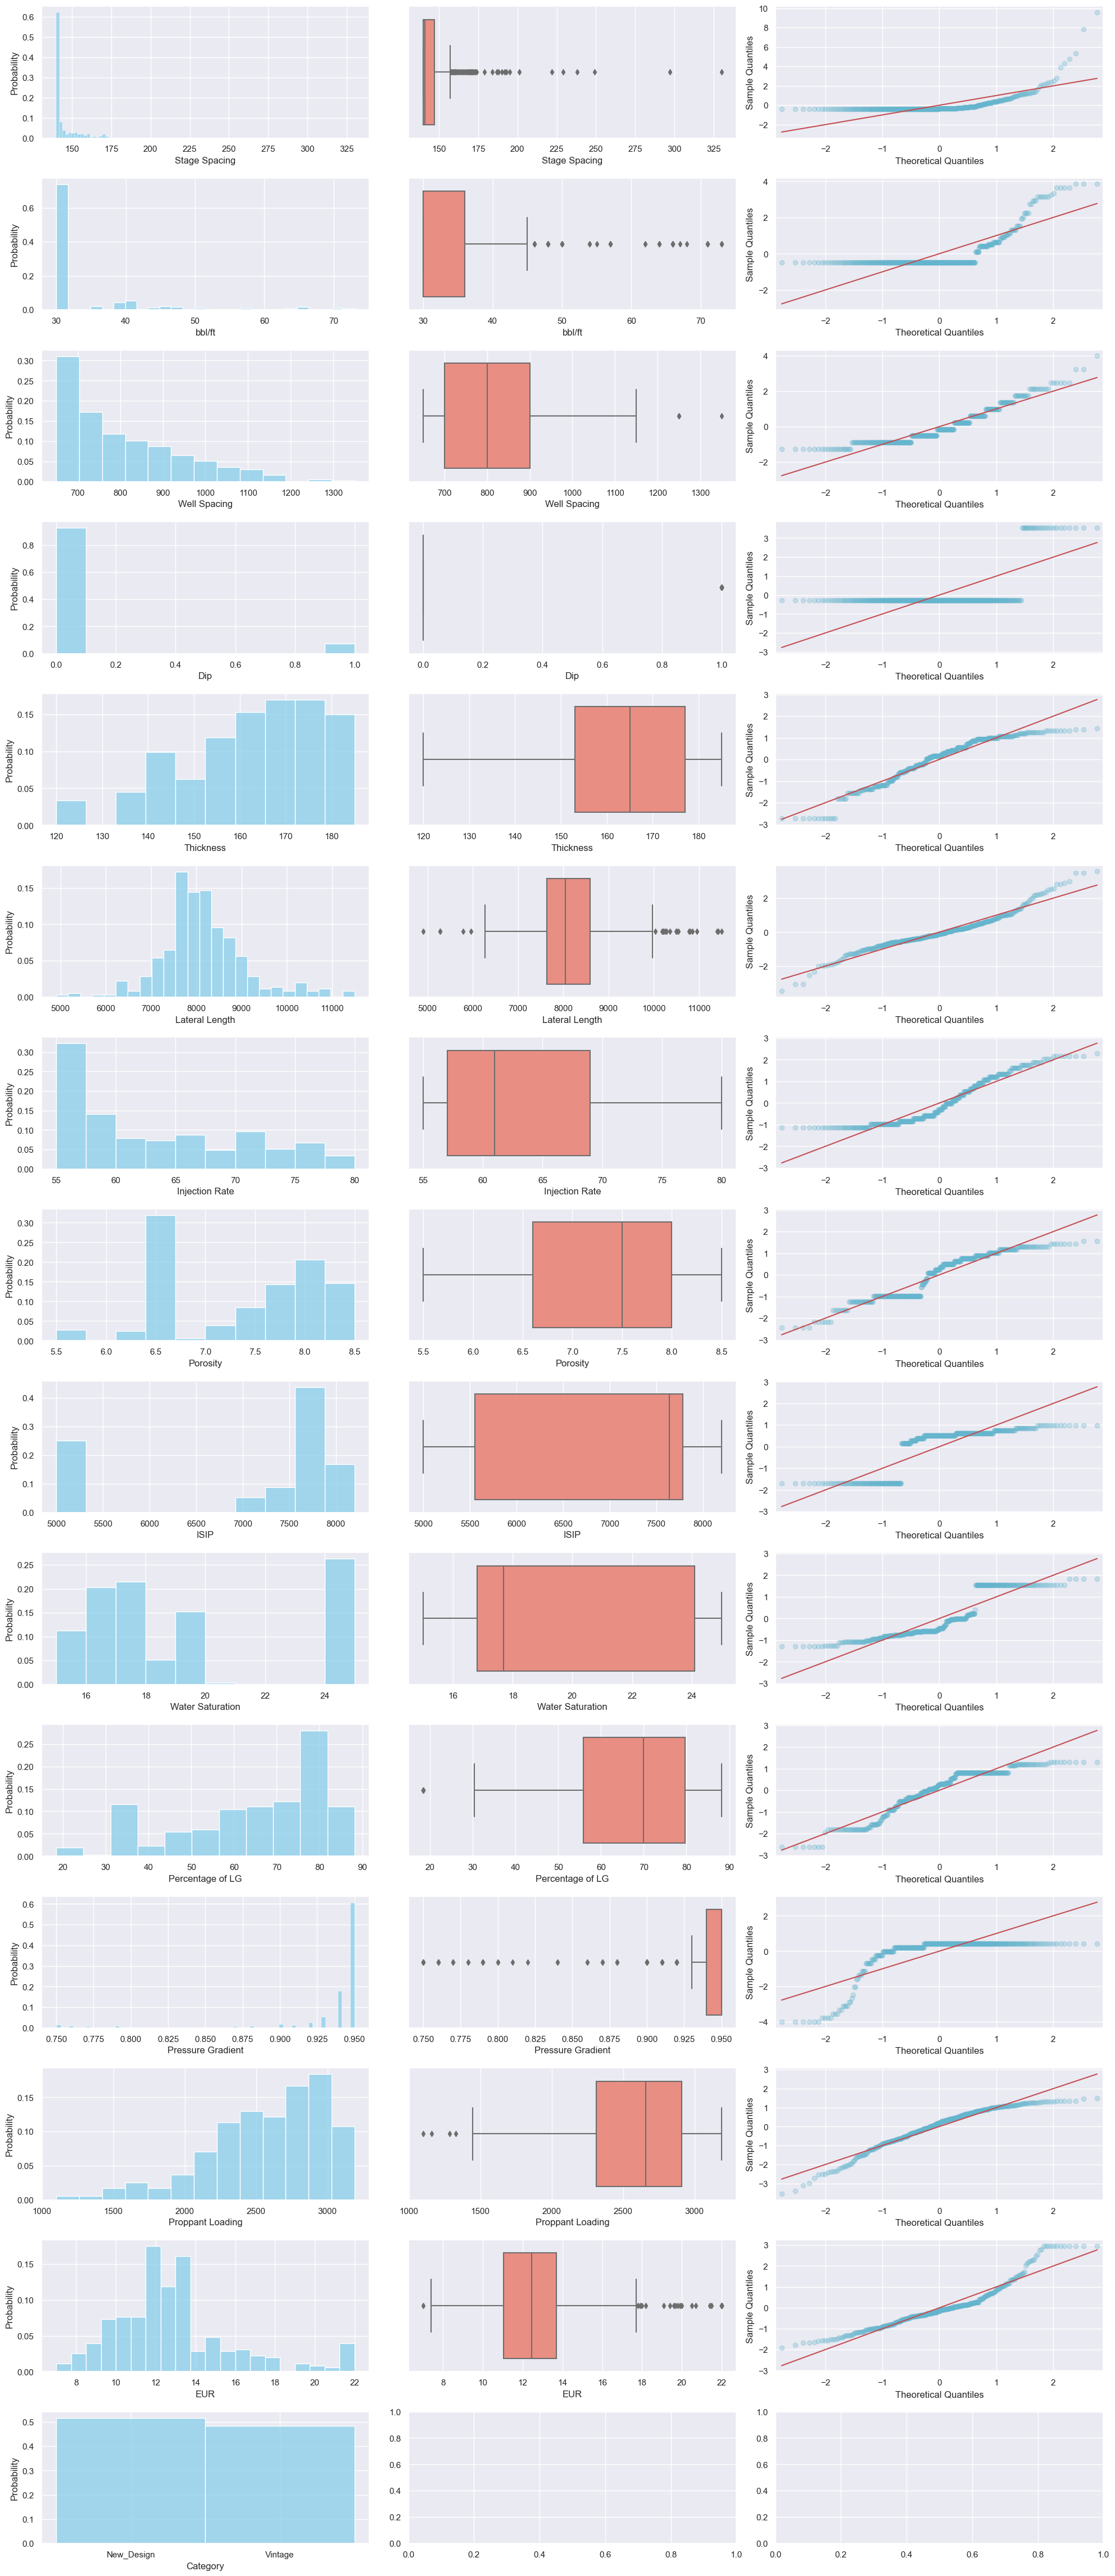

In [110]:
data_char(strat_train_set)